# Quickstart QuotaClimat

![](../coverquotaclimat.png)

> Notebook python d'exploration pour fournir une base d'analyse et de visualisation pour toute l'équipe

In [14]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime

In [152]:
import seaborn as sns

##### Charte graphique plotly

In [15]:
# CONFIG AND THEMES
COLOR_SEQUENCE = [
    "rgb(230, 50, 24)",
    "rgb(240, 73, 70)",
    "rgb(243, 127, 125)",
    "rgb(248, 182, 181)",
    "rgb(209, 220, 197)",
    "rgb(137, 168, 141)",
    "rgb(59, 111, 66)",
    "rgb(66, 66, 66)",
]

SMALL_SEQUENCE2 = [
    "rgb(230, 50, 24)",
    "rgb(59, 111, 66)",
]

WARMING_STRIPES_SEQUENCE =  ['#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
]

COLOR_SEQUENCE = COLOR_SEQUENCE #+ px.colors.qualitative.Antique
px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = COLOR_SEQUENCE

# Create Plotly theme to set as default
THEME = go.layout.Template()
THEME.layout.treemapcolorway = COLOR_SEQUENCE
THEME.layout.sunburstcolorway = COLOR_SEQUENCE
THEME.layout.colorway = COLOR_SEQUENCE
THEME.layout.piecolorway = COLOR_SEQUENCE
THEME.layout.font = {"family":"Helvetica"}
px.defaults.template = THEME

# Visualize Colormap
fig = px.bar(
    pd.DataFrame({"color":COLOR_SEQUENCE}).assign(value = lambda x : 1,palette = lambda x : "QUOTACLIMAT").append(
    pd.DataFrame({"color":WARMING_STRIPES_SEQUENCE}).assign(value = lambda x : 1,palette = lambda x : "WARMINGSTRIPES")
    ),
    x = "value",
    y = "palette",
    color = "color",
    height = 300,
    
    color_discrete_sequence=COLOR_SEQUENCE + WARMING_STRIPES_SEQUENCE
)
fig.update_layout(xaxis={"showticklabels":False,"title":""},yaxis={"title":""},showlegend=False)
fig

# Récupération des données

>  A changer plus tard une fois la base de données SQL mise en place

In [16]:
import os
os.listdir("../data/keywords")

['20221015_lastmonth_all_décroissance.xlsx',
 '20221015_lastyear_bfmtv_changement climatique.xlsx',
 '20221015_lastmonth_all_biodiversité.xlsx',
 '20221031_lastyear_all_sainte-soline.xlsx',
 '20221015_lastmonth_all_GIEC.xlsx',
 '20221015_lastmonth_all_activiste.xlsx',
 '20221015_lastmonth_all_réchauffement climatique.xlsx',
 '20221031_lastyear_all_bassine.xlsx',
 '20221015_lastmonth_all_changement climatique.xlsx',
 '20221015_lastweek_all_sobriété.xlsx']

## Lecture d'un extrait Mediatree

In [31]:
data = pd.read_excel('../data/keywords/20221031_lastyear_all_bassine.xlsx')
data.head()

,CHANNEL,RADIO,DATE,TEXT,HIGHLIGHT,START CHUNK,END CHUNK,ORIGIN,URL
0,France 3 Idf,False,2022-09-17T09-58-00,vu la taille de la bassine on y va <unk> <unk>...,vu la taille de la bassine on y va <unk> <unk>...,2022-09-17T09-58-00,2022-09-17T10-00-00,s2t,https://keywords.mediatree.fr/player/?fifo=fr3...
1,France 3 Comte,False,2022-04-12T11-48-00,matériel il nous faudra une bassine d' eau cha...,matériel il nous faudra une bassine d' eau cha...,2022-04-12T11-48-00,2022-04-12T11-50-00,s2t,https://keywords.mediatree.fr/player/?fifo=fr3...
2,LCI,False,2022-10-30T15-00-00,* - Cette situation en France toujours - Cette...,cette fameuse bassine dont le chantier est en...,2022-10-30T15-00-00,2022-10-30T15-02-00,dvb,https://keywords.mediatree.fr/player/?fifo=lci...
3,Radio Morvan,True,2021-11-01T05-56-00,un le paris nantes me passionne autant que mon...,le contrôle avec ses blagues il bassine la mo...,2021-11-01T05-56-00,2021-11-01T05-58-00,s2t,https://keywords.mediatree.fr/player/?fifo=rad...
4,France Bleu RCFM,True,2021-12-07T07-28-00,<unk> <unk> toscan on y va <unk> <unk> un chau...,appui au minot de coups une bassine <unk> son...,2021-12-07T07-28-00,2021-12-07T07-30-00,s2t,https://keywords.mediatree.fr/player/?fifo=fbl...


In [28]:
data.shape

(4340, 9)

In [19]:
channels = pd.read_excel("../data/channels.xlsx")
channels.head()

,CHANNEL,CHANNEL_NAME
0,tf1,TF1
1,france2,France 2
2,france3,France 3
3,cplus,Canal+
4,france5,France 5


## Préparation des données

In [32]:
def process_mediatree_extract(path_file,path_channels):
    data = pd.read_excel(path_file)
    channels = pd.read_excel(path_channels)
    
    data = (
        data
        #.merge(channels,on = "CHANNEL")
        .rename(columns = {"CHANNEL":"CHANNEL_NAME","START CHUNK" : "START_CHUNK","END CHUNK":"END_CHUNK"})
        .assign(DATE = lambda x : pd.to_datetime(x["DATE"],format = "%Y-%m-%dT%H-%M-%S"))
        .assign(TIME = lambda x : x["DATE"].dt.time)
        .assign(TIME = lambda x : x["TIME"].map(lambda y : datetime.timedelta(hours=y.hour, minutes=y.minute, seconds=y.second)))
        .assign(MEDIA = lambda x : x["RADIO"].map(lambda y : "Radio" if y else "TV"))
        .assign(FILENAME = lambda x : path_file)
        .assign(COUNT = lambda x : 1)
        .assign(DURATION = lambda x : 2)
        .assign(KEYWORD = lambda x : x["FILENAME"].map(lambda y : y.rsplit("_",1)[-1].replace(".xlsx","")))
        .drop(columns = ["ORIGIN","START_CHUNK","END_CHUNK"])
        
    )

    return data
    
data = process_mediatree_extract('../data/keywords/20221031_lastyear_all_bassine.xlsx',"../data/channels.xlsx")
data.head()

,CHANNEL_NAME,RADIO,DATE,TEXT,HIGHLIGHT,URL,TIME,MEDIA,FILENAME,COUNT,DURATION,KEYWORD
0,France 3 Idf,False,2022-09-17 09:58:00,vu la taille de la bassine on y va <unk> <unk>...,vu la taille de la bassine on y va <unk> <unk>...,https://keywords.mediatree.fr/player/?fifo=fr3...,0 days 09:58:00,TV,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine
1,France 3 Comte,False,2022-04-12 11:48:00,matériel il nous faudra une bassine d' eau cha...,matériel il nous faudra une bassine d' eau cha...,https://keywords.mediatree.fr/player/?fifo=fr3...,0 days 11:48:00,TV,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine
2,LCI,False,2022-10-30 15:00:00,* - Cette situation en France toujours - Cette...,cette fameuse bassine dont le chantier est en...,https://keywords.mediatree.fr/player/?fifo=lci...,0 days 15:00:00,TV,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine
3,Radio Morvan,True,2021-11-01 05:56:00,un le paris nantes me passionne autant que mon...,le contrôle avec ses blagues il bassine la mo...,https://keywords.mediatree.fr/player/?fifo=rad...,0 days 05:56:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine
4,France Bleu RCFM,True,2021-12-07 07:28:00,<unk> <unk> toscan on y va <unk> <unk> un chau...,appui au minot de coups une bassine <unk> son...,https://keywords.mediatree.fr/player/?fifo=fbl...,0 days 07:28:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine


In [140]:
data.shape

(4340, 13)

## Creation des colonnes tokens, keywords et keywords_string

In [193]:
from nltk.corpus import stopwords

In [201]:
from nltk.tokenize import wordpunct_tokenize

In [194]:
stop_words = set(stopwords.words('french'))

In [197]:
data.TEXT.str.split(" ").explode().value_counts().drop(stop_words, errors="ignore")


l'             25379
c'             19665
d'             19088
a              17086
ça             10463
               ...  
escarpins          1
indémodable        1
épatant            1
fuchs              1
liberation         1
Name: TEXT, Length: 40294, dtype: int64

In [202]:
def clean(x,stop_words_list):
    
    # Tokenization
    tokens = wordpunct_tokenize(x)
    
    # Remove stop words and remove too short tokens
    tokens = [x for x in tokens if len(x) > 3 and x not in stop_words_list]
    
    return tokens

In [204]:
data["TOKEN"] = data.TEXT.map(lambda x: clean(x,stop_words))

In [206]:
pd.set_option('display.max_rows', 500)


In [212]:
data["TOKEN"].explode().value_counts().reset_index().to_excel('TOKENS_keywords.xlsx')

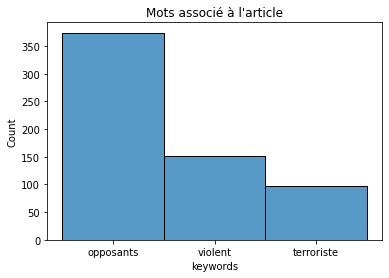

In [172]:
sns.histplot(data['keywords'].explode().value_counts(),bins=10, kde=False).set(title="Mots associé à l'article");

# Nettoyage articles sans rapports avec mégabassines

In [347]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()

In [348]:
keyword_processor.add_keyword("violent")

True

In [349]:
keyword_dict2 = {
    "violent" : ["violent", "violence", "violents", "tension", "tensions", "affrontements", "bléssés", "blessés", "dégradations", "armés"],
    "bléssés": ["bléssés", "victime", "blessés","hospitalisations", "blessures", "soins", "secours"],
    "terroriste": ["déco terrorisme", "deco terrorisme", "terroriste", "terroristes", "terrorisme"],
    "opposants": ["opposant", "opposants", "opposé", "opposés", "conflit", "militants"],
    "agricole": ["agricole", "agriculteurs", "agriculture", "producteurs", "paysans"], 
    "manifestation": ["manifestation", "manifestants", "rassemblement", "mobilisation", "manifesté", "militants", "militant"], 
    "police": ["police", "policiers", "gendarmes", "darmanin", "gendarmerie", "agents", "forces"],
    "écologie": ["écologie", "environnement", "écologique", "biodiversité", "sécheresse", "secheresses"],
    "économique": ["économique", "intérêts", "intérêts", "coûts", "coûts", "économies"], 
    "dommages" : ["dommages", "dommage", "dégradations", "dégats"],
    "politique" : ["politique", "députés", "ministres"]
}

In [350]:
keyword_processor.add_keywords_from_dict(keyword_dict2)

In [351]:
data["keywords"] = data['TEXT'].map(lambda x:list(set(keyword_processor.extract_keywords(x))))
data["keywords_string"] = data['keywords'].map(lambda x:",".join(x))

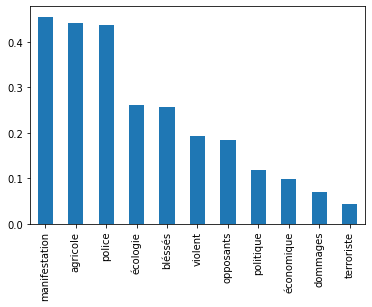

In [379]:
(data["keywords"].explode().value_counts()/len(data_megabassines)).plot(kind="bar");

In [353]:
data["keywords"].explode().value_counts()

manifestation    1053
agricole         1018
police           1011
écologie          602
bléssés           595
violent           445
opposants         423
politique         273
économique        226
dommages          162
terroriste         98
Name: keywords, dtype: int64

**Excel pour analyser les lignes qui n'obtiennent aucun tags**         
On se rend compte qu'environ la moitié ne parle pas de mégabassine, création d'un nouveau dataframe avec uniquement les bons articles (data_megabassines) 

In [314]:
data.query("keywords_string == ''").to_excel("articles_sans_tokens.xlsx")

In [364]:
data_megabassines = data.query("keywords_string != ''")

In [382]:
data["keywords"].explode().value_counts()

manifestation    1053
agricole         1018
police           1011
écologie          602
bléssés           595
violent           445
opposants         423
politique         273
économique        226
dommages          162
terroriste         98
Name: keywords, dtype: int64

In [378]:
data_megabassines

,CHANNEL_NAME,RADIO,DATE,TEXT,HIGHLIGHT,URL,TIME,MEDIA,FILENAME,COUNT,DURATION,KEYWORD,keywords,keywords_string,TOKEN
2,LCI,False,2022-10-30 15:00:00,* - Cette situation en France toujours - Cette...,cette fameuse bassine dont le chantier est en...,https://keywords.mediatree.fr/player/?fifo=lci...,0 days 15:00:00,TV,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, police]","manifestation,police","[Cette, situation, France, toujours, Cette, si..."
12,RCF Bordeaux,True,2022-01-17 18:30:00,retrouvez le journal régional rcs le journal l...,au remplissage de la bassine de mosaïque qui ...,https://keywords.mediatree.fr/player/?fifo=rcf...,0 days 18:30:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, agricole, police]","manifestation,agricole,police","[retrouvez, journal, régional, journal, journa..."
14,BFMTV,False,2022-10-30 17:02:00,julien le guet comme le disait les organisateu...,de cette bassine en l' occurrence et les tent...,https://keywords.mediatree.fr/player/?fifo=bfm...,0 days 17:02:00,TV,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,[agricole],agricole,"[julien, guet, comme, disait, organisateurs, o..."
17,8 Mont-Blanc,False,2022-06-09 10:58:00,innovante c' est toujours dit on veut que le p...,ne fonctionne pas ça fait quarante ans que qu...,https://keywords.mediatree.fr/player/?fifo=8-m...,0 days 10:58:00,TV,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,[politique],politique,"[innovante, toujours, veut, parti, politique, ..."
21,RCF Poitou,True,2022-01-17 18:30:00,tout de suite retrouvez le journal régional rc...,pour s' opposer au remplissage de la bassine ...,https://keywords.mediatree.fr/player/?fifo=rcf...,0 days 18:30:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, agricole, police]","manifestation,agricole,police","[tout, suite, retrouvez, journal, régional, jo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,NRJ Marseille,True,2022-10-31 08:04:00,trente kilomètres heure à craindre ça va aussi...,qu' on appelle une bassine plusieurs milliers...,https://keywords.mediatree.fr/player/?fifo=nrj...,0 days 08:04:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, agricole, police]","manifestation,agricole,police","[trente, kilomètres, heure, craindre, aussi, s..."
4336,NRJ La Rochelle,True,2022-10-31 08:04:00,dès vingt heures des rafales jusqu' à cent tre...,pour les agriculteurs qu' on appelle une bass...,https://keywords.mediatree.fr/player/?fifo=nrj...,0 days 08:04:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, agricole, police]","manifestation,agricole,police","[vingt, heures, rafales, jusqu, cent, trente, ..."
4337,NRJ Grenoble,True,2022-10-31 06:02:00,à metz et à reims dix sept degrés à brest ving...,une bassine plusieurs milliers de militants é...,https://keywords.mediatree.fr/player/?fifo=nrj...,0 days 06:02:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, agricole, police, bléssés]","manifestation,agricole,police,bléssés","[metz, reims, sept, degrés, brest, vingt, deux..."
4338,NRJ Clermont-Ferrand,True,2022-10-31 06:02:00,brest vingt-deux à bourg-en-bresse et à montpe...,réserve d' eau pour les agriculteurs qu' on a...,https://keywords.mediatree.fr/player/?fifo=nrj...,0 days 06:02:00,Radio,../data/keywords/20221031_lastyear_all_bassine...,1,2,bassine,"[manifestation, agricole, police, bléssés]","manifestation,agricole,police,bléssés","[brest, vingt, deux, bourg, bresse, montpellie..."


In [366]:
data_megabassines.shape

(2313, 15)

In [354]:
data.query("keywords_string != ''").to_excel("articles_megabassines.xlsx")

In [374]:
articles_manifestants = data_megabassines.loc[data["keywords"].map(lambda x : "manifestation" in x)]
articles_manifestants.shape

(1053, 15)

In [376]:
articles_manifestants.to_excel('articles_manifestants_2.xlsx')

In [390]:
count = data_megabassines.explode("keywords").groupby(["keywords", "CHANNEL_NAME"], as_index=False)['COUNT'].sum()

In [392]:
count.loc[count["CHANNEL_NAME"].isin(top_channels)]

,keywords,CHANNEL_NAME,COUNT
0,agricole,100 % Radio,1
1,agricole,8 Mont-Blanc,5
2,agricole,ARL FM,3
3,agricole,Africa Radio,1
4,agricole,Alouette,2
...,...,...,...
1342,économique,TF1,2
1343,économique,Tébéo,3
1344,économique,Tébésud,10
1345,économique,Vibration,1


In [402]:
px.area(count.loc[count["CHANNEL_NAME"].isin(top_channels_tv)],groupnorm="percent", 
       x="keywords", y="COUNT", color="CHANNEL_NAME", color_discrete_sequence= px.colors.qualitative.Prism)



In [406]:
px.bar(count.loc[count["CHANNEL_NAME"].isin(top_channels)], 
       x="CHANNEL_NAME", y="COUNT", color="keywords", color_discrete_sequence= px.colors.qualitative.Prism)



# Analyse sur un extrait keyword Mediatree 

In [34]:
top_channels = channels.head(25)["CHANNEL_NAME"].tolist()
top_channels_tv = top_channels[:8]
top_channels

['TF1',
 'France 2',
 'France 3',
 'Canal+',
 'France 5',
 'M6',
 'BFMTV',
 'CNEWS',
 'LCI',
 'Arte',
 'Europe 1',
 'RMC',
 'RTL',
 'France Inter',
 'Euronews',
 'LCP',
 'France Info',
 'France 24',
 'France S',
 'TV5Monde',
 'BFM Business Radio',
 'BFM Business',
 'France Culture',
 'Radio Classique',
 'RFI']

## Split des chaînes

In [336]:
count = data_megabassines
        .groupby(["CHANNEL_NAME","MEDIA"]
        ,as_index = False)["COUNT"].sum().sort_values("COUNT",ascending = False).head(30)

fig = px.bar(`
    count,
    x = "CHANNEL_NAME",
    y = "COUNT",
    color = "MEDIA",
    color_discrete_sequence=SMALL_SEQUENCE2,
    text_auto = ".2s",
    category_orders={"CHANNEL_NAME": count["CHANNEL_NAME"].tolist()},
    height = 500,
    title = "Nombre de mentions par chaîne"
)

fig.update_xaxes(tickangle=-45,title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b":100})
fig.show()

In [407]:
count = (data_megabassines
        .loc[data["CHANNEL_NAME"].isin(top_channels)]
        .groupby(["CHANNEL_NAME","MEDIA"],as_index = False)["COUNT"].sum().sort_values("COUNT",ascending = False)
)

fig = px.bar(
    count,
    x = "CHANNEL_NAME",
    y = "COUNT",
    color = "MEDIA",
    color_discrete_sequence=SMALL_SEQUENCE2,
    text_auto = ".2s",
    category_orders={"CHANNEL_NAME": count["CHANNEL_NAME"].tolist()},
    height = 500,
    title = "Nombre de mentions par les plus grandes chaînes "
)

fig.update_xaxes(tickangle=-45,title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b":100})
fig.show()

In [338]:
count = data_megabassines.groupby(["MEDIA"],as_index = False)["COUNT"].sum().sort_values("COUNT",ascending = False)
count

fig = px.pie(
    count,
    names = "MEDIA",
    values = "COUNT",
    color_discrete_sequence=SMALL_SEQUENCE2,
    title = "Split TV / Radio"
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## Evolution au cours du temps

In [339]:
freq = "D"

count = (
    data_megabassines.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq)],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.bar(count,x = "DATE",y = "COUNT",title = "Evolution du nombre de mention au cours du temps",height = 400)
fig.show()

In [340]:
freq = "D"

count = (
    data_megabassines.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"MEDIA"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.bar(count,
             x = "DATE",y = "COUNT",color = "MEDIA",
             title = "Evolution du nombre de mention au cours du temps par type de média",
             height = 400,color_discrete_sequence=SMALL_SEQUENCE2
)
fig.show()

In [408]:
freq = "D"

count = (
    data_megabassines.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"MEDIA"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.area(count,
             x = "DATE",y = "COUNT",color = "MEDIA",
             title = "Evolution du nombre de mention au cours du temps par type de média",height = 400,color_discrete_sequence=SMALL_SEQUENCE2
)
fig.show()

In [409]:
freq = "D"

count = (
    data_megabassines.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"MEDIA"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.area(count,
             x = "DATE",y = "COUNT",color = "MEDIA",groupnorm='fraction',
             title = "Evolution du nombre de mention au cours du temps par type de média en %",height = 400,color_discrete_sequence=SMALL_SEQUENCE2,
)
fig.update_layout(yaxis_tickformat='0%') 
fig.show()

In [42]:
freq = "6H"

count = (
    data.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"MEDIA"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.area(count,
             x = "DATE",y = "COUNT",color = "MEDIA",
             title = "Evolution du nombre de mention au cours du temps par type de média",height = 400,color_discrete_sequence=SMALL_SEQUENCE2
)
fig.show()

In [410]:
freq = "D"

count = (
    data_megabassines.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"MEDIA","CHANNEL_NAME"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

count = count.loc[count["CHANNEL_NAME"].isin(top_channels_tv)]

fig = px.line(count,
             x = "DATE",y = "COUNT",color = "CHANNEL_NAME",
             title = "Evolution du nombre de mention au cours du temps par chaîne TV",height = 400
)
fig.show()

fig = px.bar(count,
             x = "DATE",y = "COUNT",color = "CHANNEL_NAME",
             title = "Evolution du nombre de mention au cours du temps par chaîne TV",height = 400
)
fig.show()

## Heures de la journée

In [411]:
freq = "1H"

count = (
    data_megabassines
    .set_index(["TIME"])
    .groupby([pd.Grouper(freq = freq)],as_index = True)
    ["COUNT"].sum()
    .reset_index()
    .assign(TIME = lambda x: x["TIME"].map(lambda y : str(y)[7:12]))
)

fig = px.bar(
    count,
    x = "TIME",y = "COUNT",
)
fig.show()

In [46]:
count["TIME"].unique()

array(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
       '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00',
       '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00',
       '21:00', '22:00', '23:00'], dtype=object)

In [412]:
freq = "1H"

count = (
    data_megabassines
    .set_index(["TIME"])
    .groupby([pd.Grouper(freq = freq),"MEDIA"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
    .assign(TIME = lambda x: x["TIME"].map(lambda y : str(y)[7:12]))
    .sort_values("TIME",ascending = True)
)

fig = px.bar(
    count,
    text_auto = "s",
    x = "TIME",y = "COUNT",color="MEDIA",
    color_discrete_sequence=SMALL_SEQUENCE2,
    height = 400,
    category_orders={"TIME":count["TIME"].unique()},
    title = "Répartition des mentions par heure de la journée"
)
fig.show()


fig = px.area(
    count,
    x = "TIME",y = "COUNT",color = "MEDIA",groupnorm='fraction',
    category_orders={"TIME":count["TIME"].unique()},
    title = "Répartition des mentions par heure de la journée en %",height = 400,color_discrete_sequence=SMALL_SEQUENCE2,
)
fig.update_layout(yaxis_tickformat='0%') 
fig.show()

In [413]:
freq = "1H"

count = (
    data_megabassines
    .set_index(["TIME"])
    .groupby([pd.Grouper(freq = freq),"CHANNEL_NAME"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
    .assign(TIME = lambda x: x["TIME"].map(lambda y : str(y)[7:12]))
    .sort_values("TIME",ascending = True)
)

count = count.loc[count["CHANNEL_NAME"].isin(top_channels_tv)]

fig = px.bar(
    count,
    x = "TIME",y = "COUNT",color="CHANNEL_NAME",
    height = 400,
    category_orders={"TIME":count["TIME"].unique()},
    title = "Répartition des mentions par heure de la journée"
)
fig.show()


fig = px.area(
    count,
    x = "TIME",y = "COUNT",color = "CHANNEL_NAME",groupnorm='fraction',
    category_orders={"TIME":count["TIME"].unique()},
    title = "Répartition des mentions par heure de la journée en %",height = 400,
)
fig.update_layout(yaxis_tickformat='0%') 
fig.show()

### Par chaîne

In [49]:
freq = "3H"

count = (
    data
    .set_index(["TIME"])
    .groupby([pd.Grouper(freq = freq),"CHANNEL_NAME"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
    .assign(TIME = lambda x: x["TIME"].map(lambda y : str(y)[7:12]))
    .sort_values("TIME",ascending = True)
)

count = count.loc[count["CHANNEL_NAME"].isin(top_channels_tv)]

fig = px.bar(
    count,
    x = "TIME",y = "COUNT",color="CHANNEL_NAME",
    height = 400,
    category_orders={"TIME":count["TIME"].unique()},
    title = "Répartition des mentions par heure de la journée"
)
fig.show()


fig = px.area(
    count,
    x = "TIME",y = "COUNT",color = "CHANNEL_NAME",groupnorm='fraction',
    category_orders={"TIME":count["TIME"].unique()},
    title = "Répartition des mentions par heure de la journée en %",height = 400,
)
fig.update_layout(yaxis_tickformat='0%') 
fig.show()

In [23]:
count

,TIME,CHANNEL_NAME,COUNT
2,00:00,BFMTV,2
4,00:00,France 2,2
25,03:00,Canal+,1
24,03:00,BFMTV,2
81,06:00,France 2,18
66,06:00,CNEWS,1
60,06:00,BFMTV,5
491,09:00,TF1,7
342,09:00,France 2,5
331,09:00,CNEWS,5


In [50]:
freq = "4H"

def parse_period(y,freq):
    hours = int(str(y)[7:9])
    return f"{hours}-{hours+int(freq.replace('H',''))}h"

count = (
    data
    .set_index(["TIME"])
    .groupby([pd.Grouper(freq = freq),"CHANNEL_NAME"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
    .assign(TIME = lambda x: x["TIME"].map(lambda y : parse_period(y,freq)))
    .sort_values("TIME",ascending = True)
)

count = count.loc[count["CHANNEL_NAME"].isin(top_channels)]

fig = px.treemap(
    count,
    path = ["CHANNEL_NAME","TIME"],
    values = "COUNT",
)
fig

# Comparer deux fichiers

In [25]:
data_climat = process_mediatree_extract('../data/keywords/20221015_lastmonth_all_changement climatique.xlsx',"../data/channels.xlsx")
data_biodiv = process_mediatree_extract('../data/keywords/20221015_lastmonth_all_biodiversité.xlsx',"../data/channels.xlsx")
data_agg = pd.concat([data_climat,data_biodiv],axis = 0,ignore_index = True)

In [26]:
freq = "D"

count = (
    data_agg.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"KEYWORD"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.bar(count,
             x = "DATE",y = "COUNT",color = "KEYWORD",
             title = "Evolution du nombre de mention au cours du temps par mot clé",
             height = 400,color_discrete_sequence=SMALL_SEQUENCE2
)
fig.show()

In [27]:
freq = "D"

count = (
    data_agg.set_index(["DATE"])
    .groupby([pd.Grouper(freq = freq),"KEYWORD"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
)

fig = px.area(count,
             x = "DATE",y = "COUNT",color = "KEYWORD",groupnorm='fraction',
             title = "Evolution du nombre de mention au cours du temps par keyword en %",height = 400,color_discrete_sequence=SMALL_SEQUENCE2,
)
fig.update_layout(yaxis_tickformat='0%') 
fig.show()

In [28]:

count = (
    data_agg
    .groupby(["CHANNEL_NAME","MEDIA","KEYWORD"],as_index = False)
    ["COUNT"].sum()
)

count = count.loc[count["CHANNEL_NAME"].isin(top_channels_tv)]

fig = px.bar(
    count,
    x = "CHANNEL_NAME",y = "COUNT",color="KEYWORD",
    height = 400,
    title = "Répartition des mentions par mot clé par chaîne TV principale",
    color_discrete_sequence=SMALL_SEQUENCE2,
    text_auto = "s",
)
fig.show()

In [29]:
freq = "4H"

def parse_period(y,freq):
    hours = int(str(y)[7:9])
    return f"{hours}-{hours+int(freq.replace('H',''))}h"

count = (
    data_agg
    .set_index(["TIME"])
    .groupby([pd.Grouper(freq = freq),"CHANNEL_NAME","KEYWORD"],as_index = True)
    ["COUNT"].sum()
    .reset_index()
    .assign(TIME = lambda x: x["TIME"].map(lambda y : parse_period(y,freq)))
    .sort_values("TIME",ascending = True)
)

count = count.loc[count["CHANNEL_NAME"].isin(top_channels)]

fig = px.treemap(
    count,
    path = ["CHANNEL_NAME","KEYWORD","TIME"],
    values = "COUNT",
    height = 800
)
fig